# Model creation

We are trying to model the important features that influence the populartity of a game. In other words what makes a game sell well (number of owners). 

We will create a first xgboost model to determine the important features. We will then use these features to another model to predict the range of owners.

why xgboost? It is a very powerful algorithm that is able to handle a lot of data that can be skewed and partially NAN. It is also able to handle categorical data.

XGBoost is effective in capturing complex non-linear relationships between features and the target variable. Its ensemble of weak decision trees, coupled with gradient boosting, allows it to model intricate patterns in the data. In other words many iterations of decision threes that improve on the prediction error of the previous generation. We can expect XGBoost to perform well on our dataset, which has a large number of features and a non-linear relationship between features and the target variable. 

XGBoost provides mechanisms to handle imbalanced datasets, where the distribution of samples across different classes is uneven. By adjusting class weights or using sampling strategies such as oversampling or undersampling, XGBoost can address the challenges posed by imbalanced data.This is great considering how uneven our owner distribution is.

XGBoost offers valuable insights into feature importance. It calculates feature importances based on how frequently they are used in the ensemble of trees and how much they contribute to reducing the loss function. This can be beneficial in understanding the relative importance of different features in the dataset. 

## Plan 

1. Create a first model to determine the important features (Base Model)
2. Create a second model to predict the range of owners from the important features


## Setup

In [1]:
# imports 
import pandas as pd 
import warnings
import itertools
import re


import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBClassifier
import xgboost 
import pickle
import time
import numpy as np

import graphviz

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# read in data
df_prepare = pd.read_csv('../data/cleaned/steam_clean.csv')

## Prep dataset

### 1- Owners distribution

As we have seen in the EDA, the distribution of owners is very uneven. We will therefore try and predict a range of owners. In particular the bigger the the number of owners the less data we have. Thus we will regroup the last 4 ranges into one.

Text(0.5, 1.0, 'Distribution of Owner Number')

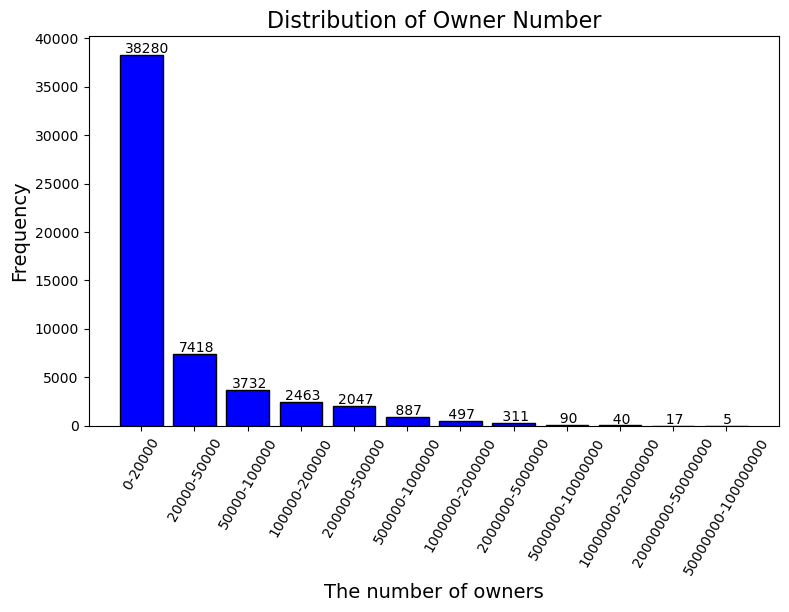

In [3]:
import matplotlib.pyplot as plt

def getMedian(x):
    '''
    Get median of range 
    '''
    x_list = [ float(x) for x in x.split("-")]
    x_median = np.median(x_list)
    return x_median

# get the information of owners

df_owner_infor = { df_tmp[0]: len(df_tmp[1]) for df_tmp in df_prepare.groupby("owners")}
df_owner_infor = { x:y for x,y in sorted(df_owner_infor.items(), key = lambda x: getMedian(x[0]))}

# Draw a distribution of owners

fig = plt.figure(figsize=[8,6])
ax = plt.gca()
plt.bar(df_owner_infor.keys(), df_owner_infor.values(), edgecolor="black", color="blue")
for idx, key in enumerate(df_owner_infor.keys()):
    ax.annotate("{:>4s}".format(str(df_owner_infor[key])), (idx-0.3, df_owner_infor[key] + 200), fontsize=10)
plt.xticks(rotation=60, fontsize=10)
plt.tight_layout(pad=2)
plt.xlabel("The number of owners", size=14)
plt.ylabel("Frequency", size=14)
plt.title("Distribution of Owner Number", size=16)

In [4]:
# change class so that 10 exist 

for idx in df_prepare.loc[df_prepare["owners"].isin(["100000000-200000000", "50000000-100000000", "20000000-50000000", "10000000-20000000"])].index:
    df_prepare.iloc[idx, 21] = 26666667

### 2- Year Game release
the values of the games released recently are skewed considering that not enough time has passed for them to reach their full potential. We will therefore only consider games released before 2023.

In [5]:
df_prepare[df_prepare['release_date'].str.contains('2023')]['owners'].value_counts()/len(df_prepare[df_prepare['release_date'].str.contains('2023')])

0-20000              0.842060
20000-50000          0.081311
50000-100000         0.045126
100000-200000        0.015326
200000-500000        0.011069
500000-1000000       0.003406
5000000-10000000     0.000851
1000000-2000000      0.000426
10000000-20000000    0.000426
Name: owners, dtype: float64

In [6]:
df_prepare['owners'].value_counts()/len(df_prepare)

0-20000               0.686181
20000-50000           0.132970
50000-100000          0.066897
100000-200000         0.044150
200000-500000         0.036693
500000-1000000        0.015900
1000000-2000000       0.008909
2000000-5000000       0.005575
5000000-10000000      0.001613
10000000-20000000     0.000717
20000000-50000000     0.000305
50000000-100000000    0.000090
Name: owners, dtype: float64

In [7]:
# drop 2023 games
df_prepare = df_prepare[~df_prepare['release_date'].str.contains('2023')]


### 3- Drop Duplicates, create columns for categories, genre and tags,Filter platform
Copy code of pre-processing from the EDA notebook and modify it to fit our needs.
We removed any dupicates and created columns for the different game categories,genre and tags we are interested in. 

In [8]:


def get_unique(series):
    """Get unique values from a Pandas series"""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # only going to use main categories
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])
    
    # only keeping 'main' genres appeared on the steam store website
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
        # 'Violent',
        # 'Web Publishing'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # remove "non-games" based on genre
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df


def pre_process():
    df = df_prepare.copy()
    
    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    
    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)
    
    return df

data = pre_process()


### 4- Day and month of release
We also want to include the days in which the game was released. We will therefore create a column for each day of the week and set it to 1 if the game was released on that day.
We are not interested in the year because it is not the choise of the publisher/developper. 

In [9]:

data.release_date = data["release_date"].astype("datetime64")
# data["release_date"].dt.year
data["day"] = data["release_date"].dt.day
data["month"] = data["release_date"].dt.month

In [10]:
# saving the data
data.to_csv('../data/cleaned/data_model.csv', index=False)

In [11]:
# create the model usalble dataframe
df_use = data.copy()

## Comparing models

We will use this correlation matrix to compare the different hyperparameters of the models and the models themselves.

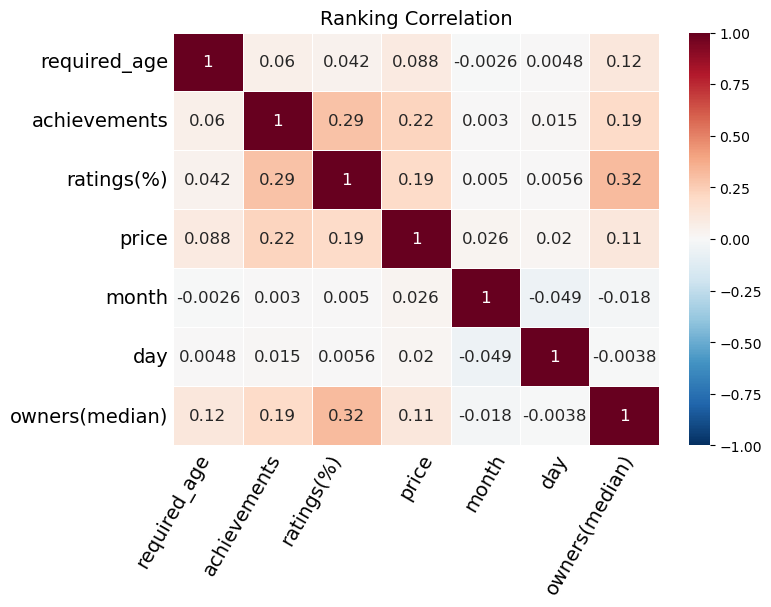

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Compute correlation matrix
correlation_matrix = df_use[["required_age", "achievements", "ratings", "price", "month", "day", "median_owners"]].corr(method="spearman")

# Create heatmap
sns.heatmap(correlation_matrix, cmap="RdBu_r", annot=True, annot_kws={"size": 12}, vmin=-1, linewidths=0.5, ax=ax)

# Set x-axis tick labels
xtick_labels = ["required_age", "achievements", "ratings(%)", "price", "month", "day", "owners(median)"]
plt.xticks([0, 1, 2, 3.5, 4.5, 5.5, 6], xtick_labels, size=14, rotation=60)

# Set y-axis tick labels
ytick_labels = ["required_age", "achievements", "ratings(%)", "price", "month", "day", "owners(median)"]
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ytick_labels, size=14)

# Remove ticks from both axes
ax.tick_params(axis='both', which='both', length=0)

# Adjust layout
plt.tight_layout()

# Set title
plt.title("Ranking Correlation", size=14)

# Save the figure
# plt.savefig("correlation.png", dpi=300)

# Show the plot
plt.show()

The highest correlation is achieved by ratings, which is 0.32. Thus, no feature shows good correlation with median owners, which indicates the challenge of this project.

## Model training

Once we have the features we want we can finally start our last model training. We will use the XGBoost algorithm to train our model. 

In [13]:
#### Change number into classes ####

warnings.filterwarnings('ignore')

# Encode owners to numeric for classification
df_use["target"] = LabelEncoder().fit_transform(df_use[["median_owners"]])


print("After conversion, there are {} classes, which are corresponding to different owner number ranges." .format(len(set(df_use["target"]))))

After conversion, there are 10 classes, which are corresponding to different owner number ranges.


In [14]:
df_use['target'].value_counts()

0    36170
1     7194
2     3610
3     2419
4     2013
5      877
6      492
7      310
8       88
9       61
Name: target, dtype: int64

In [15]:
df_use['owners'].unique()

array(['10000000-20000000', '5000000-10000000', '1000000-2000000',
       '100000-200000', '2000000-5000000', '50000000-100000000',
       '20000000-50000000', '20000-50000', '500000-1000000',
       '50000-100000', '200000-500000', '0-20000'], dtype=object)

In [16]:
#### Split dataset ####
X = df_use[['achievements', 'price','ratings','required_age','multi_player','action','adventure','casual','indie','massively_multiplayer','rpg','racing','simulation','sports','strategy','day','month']]
y = df_use['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)

In [17]:
# Create classification matrices
train_clf = xgboost.DMatrix(X_train, y_train, enable_categorical=True)
test_clf = xgboost.DMatrix(X_test, y_test, enable_categorical=True)

In [18]:
# training the model
params = {"objective": "multi:softmax", "tree_method": "exact",'colsample_bytree': '0.8' ,'learning_rate': '0.2'}
params['nthread'] = 10
params['eval_metric'] = ["mlogloss", "auc", "merror"]
params['num_class'] = len(set(df_use["target"]))

evallist = [(train_clf, 'train'), (test_clf, 'eval')]

n=1000

model = xgboost.train(
    params=params,
    dtrain=train_clf,
    num_boost_round=n,
    evals=evallist,
    verbose_eval=50,
    # Activate early stopping
    early_stopping_rounds=50,
)

# the train method is preferred because it allows for better control over training and custom metric functions. 

[0]	train-mlogloss:1.84856	train-auc:0.71930	train-merror:0.30741	eval-mlogloss:1.85448	eval-auc:0.70550	eval-merror:0.31482
[50]	train-mlogloss:0.81421	train-auc:0.81843	train-merror:0.26665	eval-mlogloss:0.95786	eval-auc:0.76517	eval-merror:0.31025
[100]	train-mlogloss:0.73581	train-auc:0.85554	train-merror:0.24579	eval-mlogloss:0.95514	eval-auc:0.77382	eval-merror:0.31044
[117]	train-mlogloss:0.71334	train-auc:0.86614	train-merror:0.24005	eval-mlogloss:0.95612	eval-auc:0.77514	eval-merror:0.31069


In [20]:
#saving the model 
model.save_model('../data/model/0001.model')

In [21]:
# predicting with our test data
ypred = model.predict(test_clf,iteration_range=(0, model.best_iteration + 1))


In [22]:
ypred.shape

(15971,)

## Performance Analysis 

### Checking accuracy

In [23]:
#### Evaluate ####
accuracy = accuracy_score(y_test, ypred.astype(int))
accuracy

0.6901258531087596

In [24]:
from sklearn.metrics import roc_curve

y_probs = model.predict(test_clf, output_margin=True)


# Calculate the false positive rate, true positive rate, and threshold values for each class
fpr = dict()
tpr = dict()
thresholds = dict()
n_classes = y_probs.shape[1]  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test, y_probs[:, i], pos_label=i)

# Print the TPR and FPR values for each class
for i in range(n_classes):
    for j in range(len(fpr[i])):
        print(f"Class: {i}  |  Threshold: {thresholds[i][j]:.2f}  |  FPR: {fpr[i][j]:.2f}  |  TPR: {tpr[i][j]:.2f}")

Class: 0  |  Threshold: 6.08  |  FPR: 0.00  |  TPR: 0.00
Class: 0  |  Threshold: 5.08  |  FPR: 0.00  |  TPR: 0.00
Class: 0  |  Threshold: 5.05  |  FPR: 0.00  |  TPR: 0.00
Class: 0  |  Threshold: 4.76  |  FPR: 0.00  |  TPR: 0.00
Class: 0  |  Threshold: 4.76  |  FPR: 0.00  |  TPR: 0.00
Class: 0  |  Threshold: 4.38  |  FPR: 0.00  |  TPR: 0.00
Class: 0  |  Threshold: 4.38  |  FPR: 0.00  |  TPR: 0.00
Class: 0  |  Threshold: 4.18  |  FPR: 0.00  |  TPR: 0.01
Class: 0  |  Threshold: 4.17  |  FPR: 0.00  |  TPR: 0.01
Class: 0  |  Threshold: 4.12  |  FPR: 0.00  |  TPR: 0.01
Class: 0  |  Threshold: 4.12  |  FPR: 0.00  |  TPR: 0.01
Class: 0  |  Threshold: 4.10  |  FPR: 0.00  |  TPR: 0.02
Class: 0  |  Threshold: 4.10  |  FPR: 0.00  |  TPR: 0.02
Class: 0  |  Threshold: 4.08  |  FPR: 0.00  |  TPR: 0.02
Class: 0  |  Threshold: 4.08  |  FPR: 0.00  |  TPR: 0.02
Class: 0  |  Threshold: 4.07  |  FPR: 0.00  |  TPR: 0.02
Class: 0  |  Threshold: 4.07  |  FPR: 0.00  |  TPR: 0.02
Class: 0  |  Threshold: 4.06  |

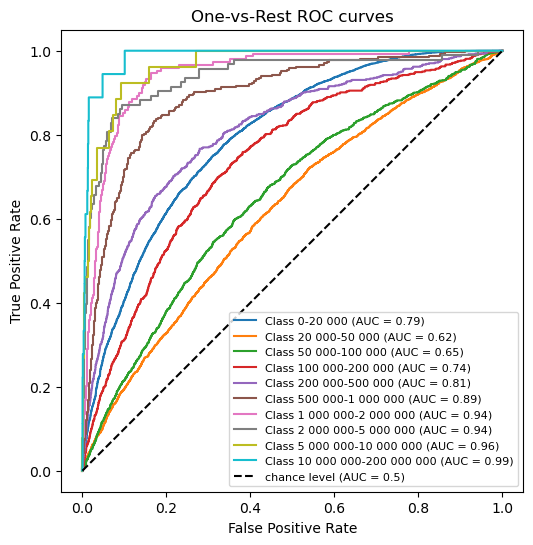

In [25]:
# plotting the ROC curve (FPR vs TPR)
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics

y_probs = model.predict(test_clf, output_margin=True)


# Calculate the false positive rate, true positive rate, and threshold values for each class
fpr = dict()
tpr = dict()
thresholds = dict()
n_classes = y_probs.shape[1]  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test, y_probs[:, i], pos_label=i)

classes = ['0-20 000', '20 000-50 000', '50 000-100 000', '100 000-200 000','200 000-500 000','500 000-1 000 000','1 000 000-2 000 000','2 000 000-5 000 000','5 000 000-10 000 000','10 000 000-200 000 000']

plt.figure(figsize=(8, 6))  # Set the figure size

# Print the TPR and FPR values for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {metrics.auc(fpr[i], tpr[i]):.2f})")

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend(fontsize='8', loc='lower right')

plt.show()


Compared with the highest correlations got by single features (0.32), our model still can achieve **much better performance** in owner prediction (around 70% accuracy). Furthermore, the Roc curves for all classes are above 0.5 AUC, which means our model is better than random guess. However the model is not perfect and we can see that the model over predicts games with the lowest number of owners and under predicts for higher number of owners. This is due to the fact that we have very little data for popular games. 
From the ROC curves we can see that our model predicts poorly the games with the low number of owners(20k to 100k with less than 0.7 AUC) compared to other classes. That is because it tends to over classify instances into those classes. Whereas if the the model tells you that an instance is in the 10th class (10M to 200M) the result is more likely true (0.99 AUC). 

bear in mind that : If the curve is closer to the top-left corner, it suggests a higher true positive rate for a lower false positive rate, indicating good discrimination between the classes. A curve that is close to the diagonal line (45-degree line) implies that the model's performance is similar to random guessing. while An AUC of 0.5 suggests no discrimination power, and an AUC of 1 indicates perfect classification.

All of this is more clear in the classification report under.

In [26]:
#Measuring accuracy on Testing Data and print them 
from sklearn import metrics
print(metrics.classification_report(y_test, ypred))
print(metrics.confusion_matrix(y_test, ypred))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84     10852
           1       0.23      0.03      0.05      2158
           2       0.13      0.02      0.03      1083
           3       0.26      0.04      0.07       726
           4       0.29      0.17      0.21       604
           5       0.20      0.10      0.14       263
           6       0.21      0.17      0.19       148
           7       0.22      0.18      0.20        93
           8       0.33      0.04      0.07        26
           9       0.12      0.06      0.08        18

    accuracy                           0.69     15971
   macro avg       0.27      0.18      0.19     15971
weighted avg       0.56      0.69      0.59     15971

[[10743    51     9    11    21     9     5     2     1     0]
 [ 2020    57    22    12    27    13     5     1     0     1]
 [  950    36    17    20    37    14     6     2     1     0]
 [  537    37    25    31    69    16     7     3   

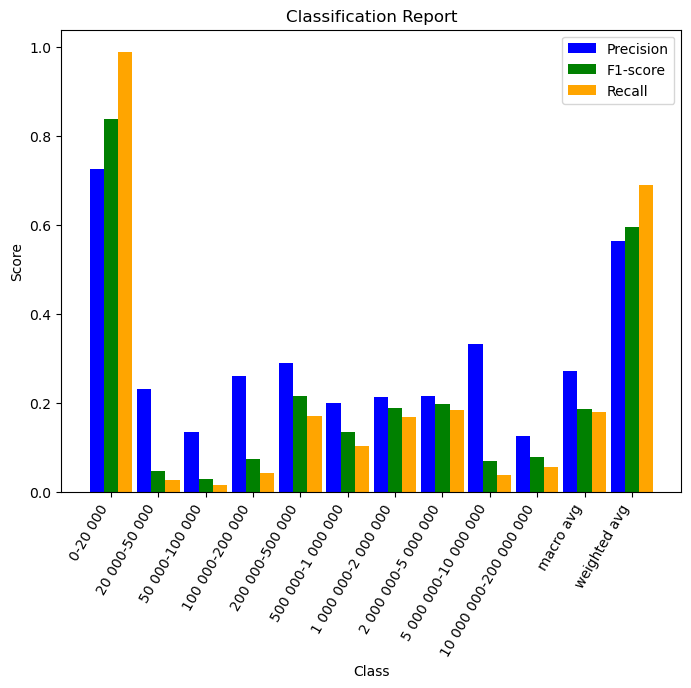

In [27]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have y_test and y_pred as your true labels and predicted labels, respectively

# Generate the classification report
report = metrics.classification_report(y_test, ypred, output_dict=True)

# Extract precision, recall, and F1-score from the report
precision = [report[label]['precision'] for label in report.keys() if label != 'accuracy']
recall = [report[label]['recall'] for label in report.keys() if label != 'accuracy']
f1_score = [report[label]['f1-score'] for label in report.keys() if label != 'accuracy']
labels = [label for label in report.keys() if label != 'accuracy']
classes = ['0-20 000', '20 000-50 000', '50 000-100 000', '100 000-200 000','200 000-500 000','500 000-1 000 000','1 000 000-2 000 000','2 000 000-5 000 000','5 000 000-10 000 000','10 000 000-200 000 000']
labels = classes + labels[-2:]

# Set the width of each bar
bar_width = 0.3

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate the x-positions for each group of bars
index = np.arange(len(labels))

# Plot precision bars
ax.bar(index, precision, width=bar_width, color='blue', label='Precision')

# Plot recall bars next to precision bars
ax.bar(index + bar_width , f1_score, width=bar_width, color='green', label='F1-score')

# Plot F1-score bars next to precision and recall bars
ax.bar(index + 2*  bar_width, recall, width=bar_width, color='orange', label='Recall')

# Customize plot aesthetics
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Classification Report')

ax.set_xticks(index + bar_width)  # Set the x-ticks at the center of each group of bars
ax.set_xticklabels(labels, rotation=60, ha='right')  # Set the x-tick labels as the class names, rotated by 60 degrees

# Move the labels to the left

ax.legend()

# Show the plot
plt.show()

bear in mind that : 

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

As we can see the recall is higher than the precision only for the 0-20 000 owners class. This means that the model is better at identifying the positive instances of that class out of all the actual positive instances present in the dataset (high recall), but it may also produce more false positives (low precision). In other words, the model is more likely to classify instances as belonging to that class, but some of those instances may be incorrect.
It implies that the model has a higher chance of capturing most of the instances of that class but may have a lower accuracy in correctly identifying only the true positives.

Comparatively, the other classes have lower recall than precision. This means that the model is better at accurately identifying positive instances for that class (high precision), but it may miss some of the actual positive instances (low recall). In other words, when the model predicts a positive instance for that class, it is likely to be correct, but it may fail to identify all the positive instances present in the dataset.

Based on the F1 Scores, the model has great performance for really low number(0-20k) of owners and average for relatively high of owners (200k to 2M). However it is not able to predict the games in the middle (20 000 - 200 000 owners) as well. However it gives us a good idea of the probability of failure for the game. 


## Error Analysis

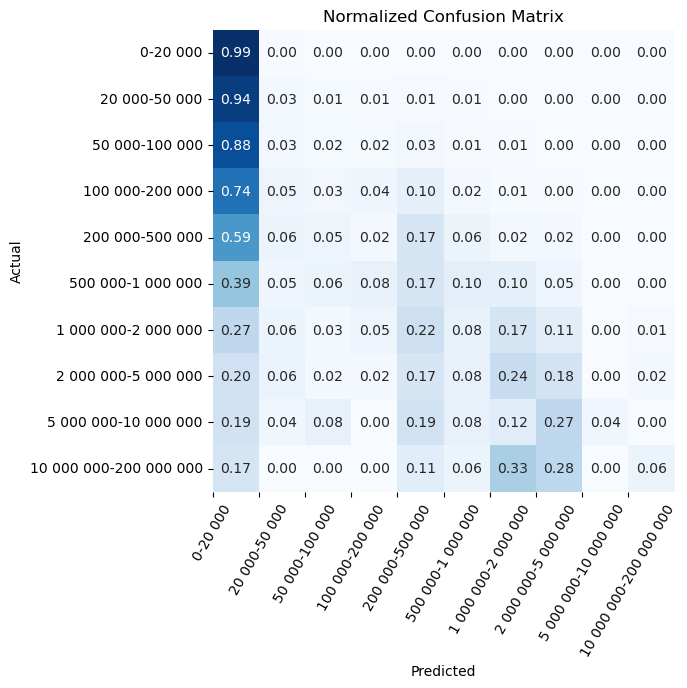

In [28]:
# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, ypred)

# Normalize the confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Create labels for the matrix
# labels = np.unique(np.concatenate((y_test, ypred)))


labels = ['0-20 000', '20 000-50 000', '50 000-100 000', '100 000-200 000','200 000-500 000','500 000-1 000 000','1 000 000-2 000 000','2 000 000-5 000 000','5 000 000-10 000 000','10 000 000-200 000 000']


# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=False, square=True, xticklabels=labels, yticklabels=labels)

# Customize plot aesthetics
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.xticks(rotation=60)  # Rotate x-axis labels

# Set custom x-axis tick labels
plt.xticks(range(len(labels)), labels, size=10)


# Show the plot
plt.show()

The normalised confusion matrix tells us the same thing discussed before that is the except for the 0-20k owners class the model is not able to predict the other classes as well. It tends to over predict the 0-20k owners class (especially putting more then 50% of the actual 20k to 500k owner games into the under 20k cathegory) and under predict the other classes.

In [29]:
TestingDataResults=pd.DataFrame(data=X_test, columns=['achievements', 'price','ratings','required_age','multi_player','action','adventure','casual','indie','massively_multiplayer','rpg','racing','simulation','sports','strategy'])
TestingDataResults['TargetColumn']= y_test
TestingDataResults['Prediction']= ypred
TestingDataResults.head()

achievements  price    ratings  required_age  multi_player  action  \
53923             4   4.99  59.416365           0.0             1       0   
15518             0   3.99  64.079515           0.0             0       0   
3635             20   4.99  50.046376           0.0             0       0   
8465             23   4.99  56.939546           0.0             0       1   
29129            26   3.99  22.353124           0.0             0       1   

       adventure  casual  indie  massively_multiplayer  rpg  racing  \
53923          0       0      0                      0    0       0   
15518          1       0      1                      0    1       0   
3635           1       1      0                      0    0       1   
8465           1       0      1                      0    0       0   
29129          0       0      1                      0    0       0   

       simulation  sports  strategy  TargetColumn  Prediction  
53923           1       0         1             1         0.0  
15518           0       0         1             0         0.0  
3635            0       0         0             0         0.0  
8465            0       0         0             1         0.0  
29129           0       0         0             0         0.0

## Feature importance

As we can see compared to the correlation matrix the features that weight the most in our model are mainly ratings, number of achievements, price and when the game is realeased. 

Do not forget that the ratings we consider are collected after release however we can obtain the rating from a beta test of the game to get a feel of the potential response from users. The number of achievements is also a good indicator of the quality of the game because it means more content for it and sens of accomplishment. The price insentivises people to play it, especially if its free. Finally the date and month of release also play on the success of the game.

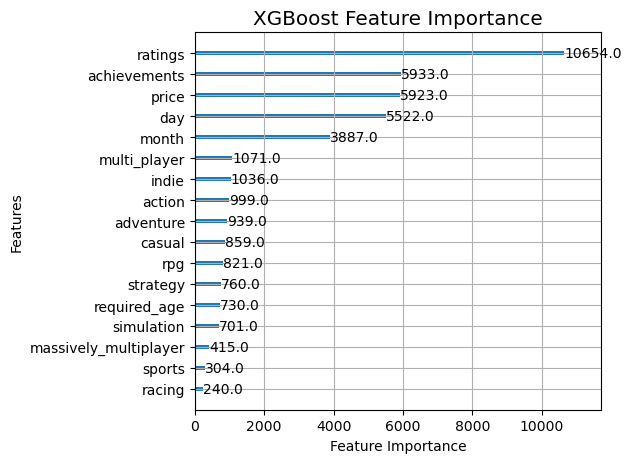

In [30]:
xgboost.plot_importance(model)


# Customize the plot aesthetics
plt.rcParams["figure.figsize"] = (8, 6)  # Set the figure size
plt.rcParams["font.size"] = 12  # Set the font size for axis labels and ticks

plt.xlabel("Feature Importance")  # Set the x-axis label
plt.ylabel("Features")  # Set the y-axis label
plt.title("XGBoost Feature Importance")  # Set the plot title

plt.tight_layout()  # Adjust the spacing between subplots

# Show the plot
plt.show()

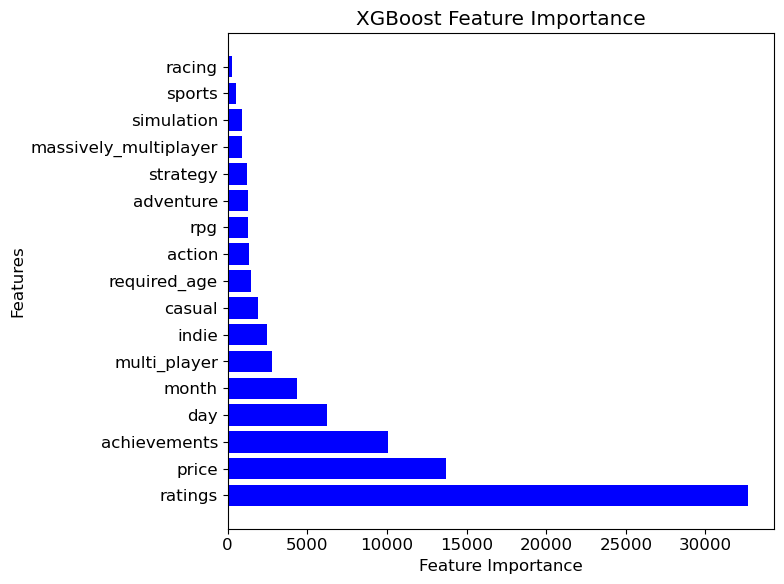

In [31]:
# another for feature importance scores
importance_scores = model.get_score(importance_type='total_gain')

# Sort the feature importance scores by value in descending order
sorted_scores = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

# Get the sorted feature names and scores
sorted_names = [feat for feat, _ in sorted_scores]
sorted_weights = [weight for _, weight in sorted_scores]

# Create a horizontal bar plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_names)), sorted_weights, color='b')
plt.yticks(range(len(sorted_names)), sorted_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

## Inside the model 

A breaf view of how the model works.

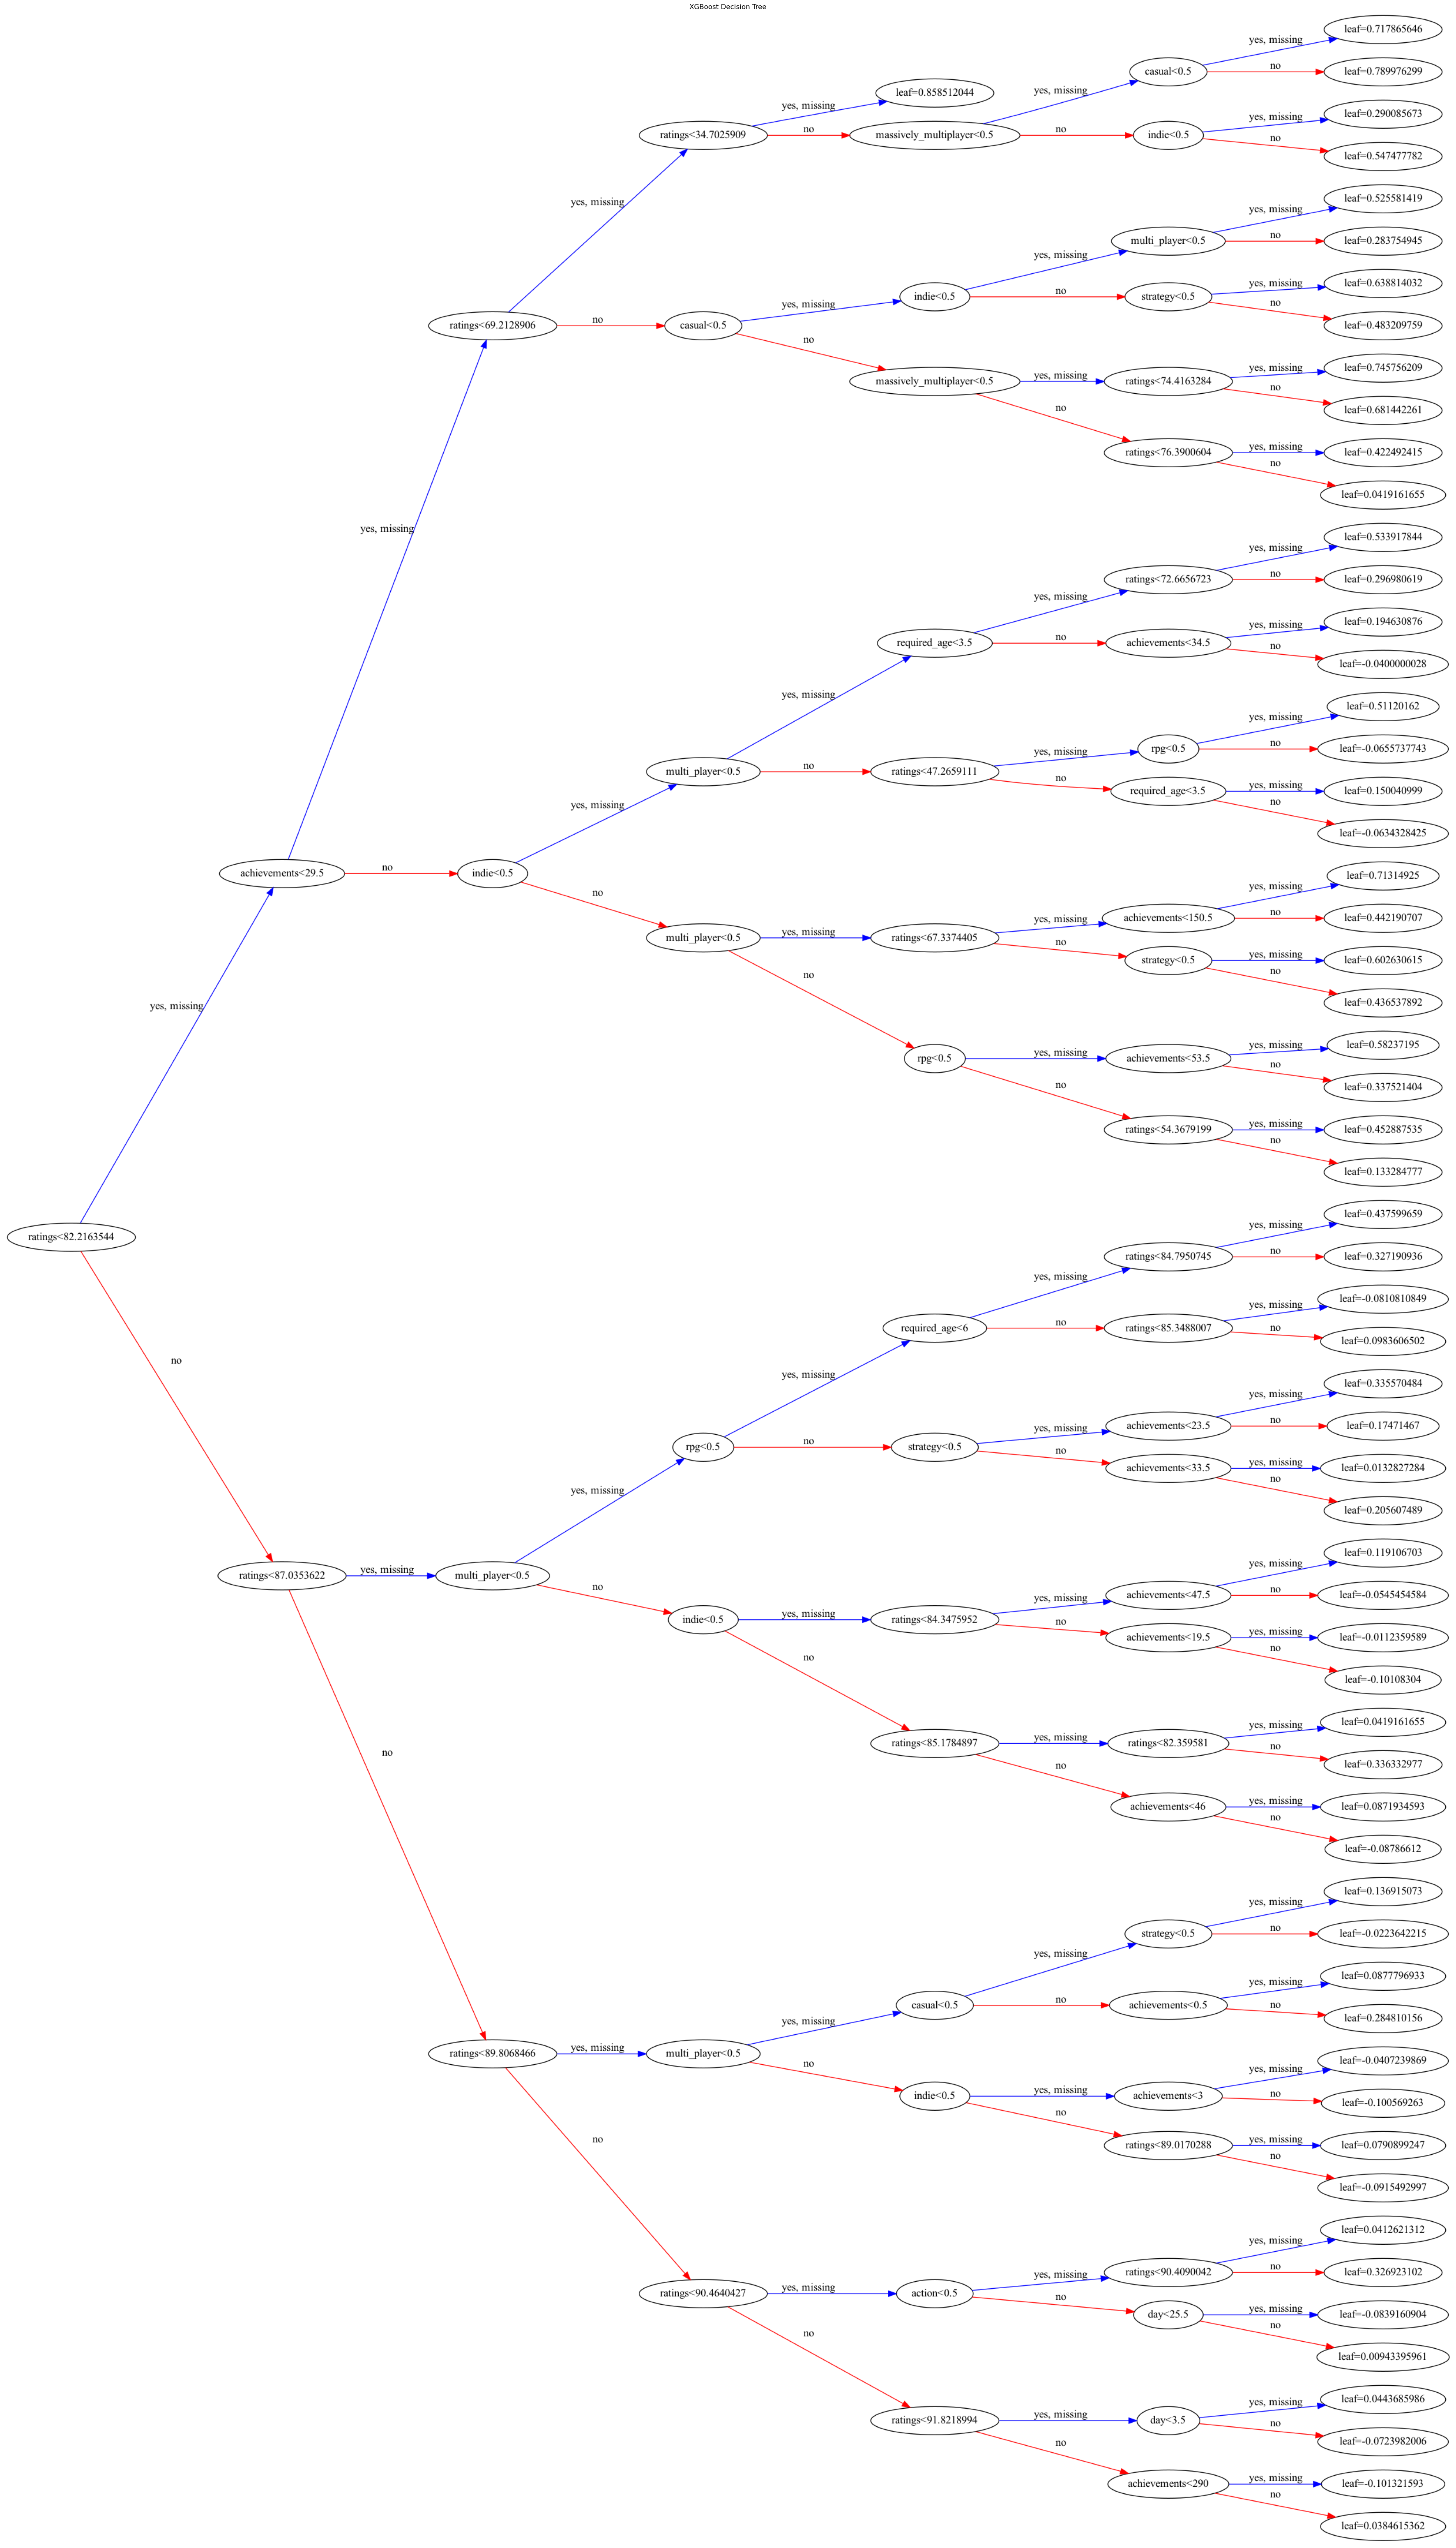

In [33]:
xgboost.plot_tree(model, num_trees=0, rankdir="LR")

# Customize the plot aesthetics
plt.rcParams["figure.figsize"] = (120, 80)  # Set the figure size
plt.rcParams["font.size"] = 10  # Set the font size for axis labels and ticks

plt.xlabel("Feature")  # Set the x-axis label
plt.ylabel("Value")  # Set the y-axis label
plt.title("XGBoost Decision Tree")  # Set the plot title


# Show the plot
plt.show()

# Conclusion

The machine learning model developed based on XGBoost for predicting Steam game owner numbers has shown promising results with an accuracy of approximately 70% on the validation and test sets. This performance surpasses the highest correlation achieved by individual numerical features, indicating the effectiveness of our model in capturing complex relationships.

Through our analysis, we have identified several key factors that game developers should consider when aiming to build successful games. Firstly, achieving a good positive ratings percentage during inner-testing plays a significant role. Additionally, setting a reasonable game price, such as opting for a free-to-play model when feasible, can contribute to higher ownership numbers. Creating many achievements is also an important considerations. Lastly, selecting an auspicious release date can enhance the chances of success.

However, it is crucial to acknowledge that our current model has limitations, as it primarily focuses on the external factors influencing game performance. The true success of a game is determined by its quality, including aspects like animation, user experience, graphic design, and story development. These factors were not incorporated into our analysis, and future work should aim to incorporate features related to game quality to further improve the predictive capabilities of our model.

In summary, our XGBoost-based model has demonstrated its potential in predicting game owner numbers based on external factors. By considering the identified factors and incorporating additional features related to game quality, we can enhance our understanding and predictive accuracy, ultimately aiding game developers in making informed decisions to maximize their game's success.

# Research crumbs 

This is stuff that was abandoned but might be useful later on. Like cross validation models or embedding layers which might be interesting topics that we don't have time neither the knowledge to explore.

In [149]:
params = {"objective": "multi:softprob", "tree_method": "exact", "num_class": 10}
n = 1000


results = xgboost.cv(
   params, train_clf,
   num_boost_round=n,
   # for cross validation use folds
   nfold=10,
   metrics=["mlogloss", "auc", "merror"],
   # Activate early stopping so that the model stops training when it no longer improves
   early_stopping_rounds=30,
)

In [150]:
results.keys()

Index(['train-mlogloss-mean', 'train-mlogloss-std', 'train-auc-mean',
       'train-auc-std', 'train-merror-mean', 'train-merror-std',
       'test-mlogloss-mean', 'test-mlogloss-std', 'test-auc-mean',
       'test-auc-std', 'test-merror-mean', 'test-merror-std'],
      dtype='object')

In [151]:
results



train-mlogloss-mean  train-mlogloss-std  train-auc-mean  train-auc-std  \
0              1.643038            0.001318        0.730002       0.000823   
1              1.423880            0.001504        0.739968       0.001024   
2              1.287543            0.001691        0.746220       0.000650   
3              1.194101            0.002007        0.750964       0.000759   
4              1.126811            0.001908        0.755247       0.000792   
5              1.076529            0.001765        0.759104       0.000969   
6              1.037695            0.001613        0.763406       0.001411   
7              1.006865            0.001688        0.768374       0.001531   
8              0.981519            0.001534        0.773435       0.001048   
9              0.960767            0.001251        0.777564       0.001125   
10             0.943387            0.001240        0.780867       0.001075   
11             0.928259            0.001281        0.784237       0.001294   
12             0.915151            0.001508        0.787443       0.001321   
13             0.903699            0.001496        0.790184       0.001070   
14             0.893610            0.001637        0.792929       0.001090   
15             0.884552            0.001789        0.795621       0.001396   
16             0.876335            0.001816        0.798333       0.001304   
17             0.869207            0.002226        0.800351       0.001584   
18             0.862758            0.002334        0.802311       0.001663   
19             0.856805            0.002470        0.804179       0.001711   
20             0.850748            0.002169        0.806314       0.001516   
21             0.845895            0.002335        0.807752       0.001639   
22             0.841050            0.002394        0.809565       0.001615   
23             0.836632            0.002580        0.811061       0.001682   
24             0.832386            0.002590        0.812508       0.001488   
25             0.828156            0.002375        0.814117       0.001229   
26             0.824380            0.002450        0.815443       0.001310   
27             0.820892            0.002455        0.816605       0.001345   
28             0.816921            0.002215        0.818218       0.001123   
29             0.812976            0.002356        0.820144       0.001192   
30             0.809549            0.002184        0.821613       0.001145   
31             0.806128            0.002618        0.823217       0.001443   
32             0.802988            0.002726        0.824590       0.001603   
33             0.799905            0.002917        0.825832       0.001775   
34             0.796193            0.002897        0.827767       0.001755   

    train-merror-mean  train-merror-std  test-mlogloss-mean  \
0            0.303417          0.000947            1.655528   
1            0.300137          0.001039            1.445117   
2            0.298410          0.001076            1.317115   
3            0.296425          0.000870            1.231078   
4            0.295229          0.000729            1.170301   
5            0.293720          0.000773            1.126710   
6            0.292339          0.000716            1.094493   
7            0.291021          0.000702            1.069844   
8            0.289605          0.000723            1.050818   
9            0.288323          0.000644            1.036369   
10           0.287008          0.000639            1.024676   
11           0.285779          0.000681            1.015552   
12           0.284491          0.000821            1.007835   
13           0.283054          0.000713            1.001919   
14           0.281730          0.000769            0.996758   
15           0.280421          0.000578            0.992817   
16           0.279404          0.000562            0.989297   
17           0.278033          0.000641            0.986565  

In [152]:
results['test-auc-mean'].max()

0.756356888407487

In [160]:
#### fit the model ####

model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=1000, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy=None, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', predictor=None, ...)

In [153]:
#### Predict ####

y_pred = model.predict(X_test)
y_pred

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [53]:
#### Evaluate ####
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.669713856364661

In [154]:
clf=XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=1000, objective='multi:softprob', booster='gbtree')


In [155]:
#Creating the model on Training Data
XGB=clf.fit(X_train,y_train)
prediction=XGB.predict(X_test)

#Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84     10852
           1       0.20      0.03      0.05      2158
           2       0.18      0.03      0.05      1083
           3       0.23      0.04      0.07       726
           4       0.25      0.15      0.18       604
           5       0.21      0.14      0.17       263
           6       0.19      0.12      0.15       148
           7       0.26      0.25      0.25        93
           8       0.08      0.04      0.05        26
           9       0.20      0.06      0.09        18

    accuracy                           0.69     15971
   macro avg       0.25      0.18      0.19     15971
weighted avg       0.56      0.69      0.60     15971

[[10699    74    24    13    26    10     4     1     1     0]
 [ 1993    65    26    17    35    13     5     2     1     1]
 [  925    49    29    24    35    12     7     1     1     0]
 [  518    49    30    29    66    24     6     2   

In [157]:
#Plotting the feature importance for Top 10 most important columns
import matplotlib.pyplot as plt
%matplotlib inline
feature_importances = pd.Series(XGB.feature_importances_, index=['achievements', 'price','ratings','required_age','multi_player','action','adventure','casual','indie','massively_multiplayer','rpg','racing','simulation','sports','strategy','day','month'])
feature_importances.nlargest(25).plot(kind='barh')

<Axes: >

In [158]:
#Printing some sample values of prediction
TestingDataResults=pd.DataFrame(data=X_test, columns=['achievements', 'price','ratings','required_age','multi_player','action','adventure','casual','indie','massively_multiplayer','rpg','racing','simulation','sports','strategy'])
TestingDataResults['TargetColumn']=y_test
TestingDataResults['Prediction']=prediction
TestingDataResults.head()

achievements  price    ratings  required_age  multi_player  action  \
53923             4   4.99  59.416365           0.0             1       0   
15518             0   3.99  64.079515           0.0             0       0   
3635             20   4.99  50.046376           0.0             0       0   
8465             23   4.99  56.939546           0.0             0       1   
29129            26   3.99  22.353124           0.0             0       1   

       adventure  casual  indie  massively_multiplayer  rpg  racing  \
53923          0       0      0                      0    0       0   
15518          1       0      1                      0    1       0   
3635           1       1      0                      0    0       1   
8465           1       0      1                      0    0       0   
29129          0       0      1                      0    0       0   

       simulation  sports  strategy  TargetColumn  Prediction  
53923           1       0         1             1           0  
15518           0       0         1             0           0  
3635            0       0         0             0           0  
8465            0       0         0             1           0  
29129           0       0         0             0           0

In [159]:
#### Evaluate ####
accuracy = accuracy_score(y_test, prediction)
accuracy

0.6881222215265168

remark: still interested in the concept of  __"use of embeddings for categorical variables"__ 
